In [26]:
#load the required libraries
import pandas as pd
import datetime
import numpy as np
import scipy 
import sklearn
from matplotlib import pyplot as plt
import statsmodels.api as sm
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,6

In [2]:
#reading the csv file
bbazar = pd.read_excel('bigbazar_dataset.xlsx')

In [3]:
bbazar.head(3)

,customerID,DOB,Gender,State,PinCode,transactionDate,store_code,store_description,till_no,transaction_number_by_till,promo_code,promotion_description,product_code,product_description,sale_price_after_promo,discountUsed
0,BBID_20482,1975-10-20 00:00:00,male,MADHYA PRADESH,453441.0,2016-05-01,2655,BB-INDORE-MALHAR MEGA MALL,2,85246,NONPROMO,NaN,1000446431,PATANJALI CHOCOS 125g,55.00,Payback
1,BBID_20485,1955-07-21 00:00:00,female,NaN,999999.0,2017-03-09,2655,BB-INDORE-MALHAR MEGA MALL,8,78829,NONPROMO,NaN,1000010431,SOO FRESH ROLLS HOT DOG 4P,30.00,Payback
2,BBID_20498,1981-03-19 00:00:00,female,MAHARASHTRA,400064.0,2015-08-12,2655,BB-INDORE-MALHAR MEGA MALL,13,1064,971754,AD 399 FLAT LADIES JEANS FASHION EXC,1000077851005,"DLJ-0010-BSF-2-CJ-FL, 34, BLACK",418.95,Payback


In [4]:
print(bbazar.dtypes)

customerID                            object
DOB                                   object
Gender                                object
State                                 object
PinCode                              float64
transactionDate               datetime64[ns]
store_code                             int64
store_description                     object
till_no                                int64
transaction_number_by_till             int64
promo_code                            object
promotion_description                 object
product_code                           int64
product_description                   object
sale_price_after_promo               float64
discountUsed                          object
dtype: object


### Using only Transaction date and Sales coulmn to build our time series model

In [6]:
ts_data = bbazar[['transactionDate','sale_price_after_promo']]

In [14]:
print(ts_data.dtypes)

transactionDate           datetime64[ns]
sale_price_after_promo           float64
dtype: object


In [20]:
ts_data_monthly = ts_data.groupby('transactionDate').sum()

In [21]:
print(ts_data_monthly.dtypes)

sale_price_after_promo    float64
dtype: object


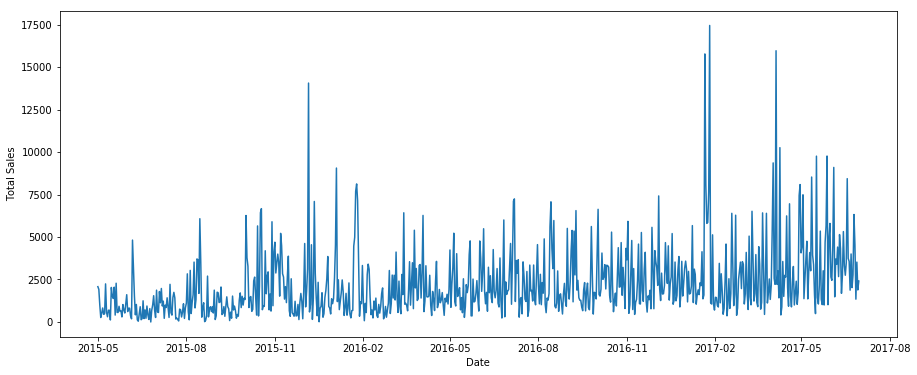

In [29]:
#plot the graph

plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.plot(ts_data_monthly)

In [33]:
#rolling statistics 
rolmean = ts_data_monthly.rolling(window=365).mean()
rolstd = ts_data_monthly.rolling(window=365).std()

print(rolmean, rolstd)

                 sale_price_after_promo
transactionDate                        
2015-05-01                          NaN
2015-05-02                          NaN
2015-05-03                          NaN
2015-05-04                          NaN
2015-05-05                          NaN
2015-05-06                          NaN
2015-05-07                          NaN
2015-05-08                          NaN
2015-05-09                          NaN
2015-05-10                          NaN
2015-05-11                          NaN
2015-05-12                          NaN
2015-05-13                          NaN
2015-05-14                          NaN
2015-05-15                          NaN
2015-05-16                          NaN
2015-05-17                          NaN
2015-05-18                          NaN
2015-05-19                          NaN
2015-05-20                          NaN
2015-05-21                          NaN
2015-05-22                          NaN
2015-05-23                          NaN


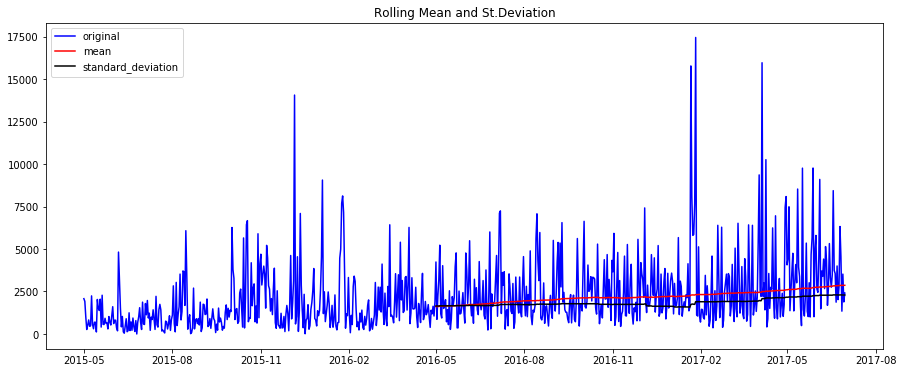

In [35]:
#plotting rolling statistics
original = plt.plot(ts_data_monthly, color = 'blue', label = 'original')
mean = plt.plot(rolmean, color = 'red', label = 'mean')
std = plt.plot(rolstd, color = 'black', label = 'standard_deviation')
plt.legend(loc = 'best')
plt.title("Rolling Mean and St.Deviation")
plt.show(block = False)

In [38]:
#dickey fuller test
from statsmodels.tsa.stattools import adfuller
from pandas import Series

print('Results of Dickey Fuller Test : ')

dftest = adfuller(ts_data_monthly['sale_price_after_promo'], autolag = 'AIC')

dfoutput = pd.Series(dftest[0:4], index = ['test Statistic', 'p-value', '#lags Used', 'Number of observations used'])
for key,value in dftest[4].items():
    dfoutput['Critical value (%s)' %key] = value
print(dfoutput)

Results of Dickey Fuller Test : 
test Statistic                  -3.572168
p-value                          0.006316
#lags Used                      20.000000
Number of observations used    769.000000
Critical value (1%)             -3.438882
Critical value (5%)             -2.865306
Critical value (10%)            -2.568775
dtype: float64


### to remove seasonality in the data, we will do seasonal differencing 

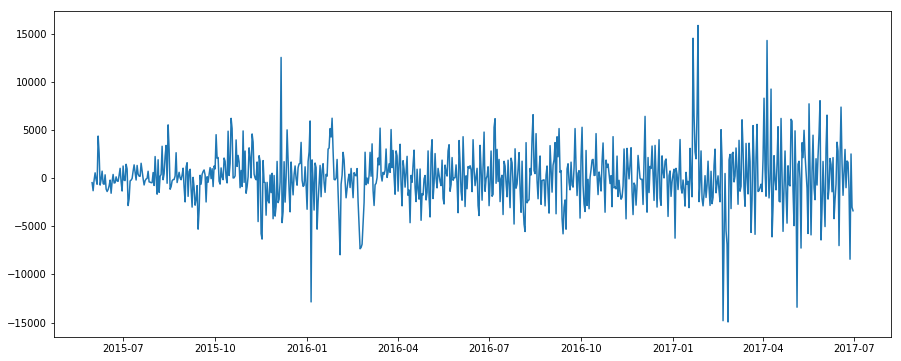

In [58]:
seasonal_differenced = ts_data_monthly - ts_data_monthly.shift(30)
plt.plot(seasonal_differenced)

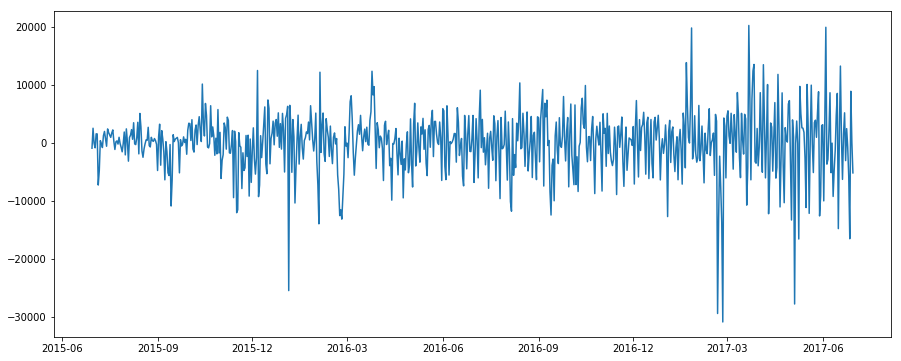

In [60]:
seas_diff1 = seasonal_differenced - seasonal_differenced.shift(30)
plt.plot(seas_diff1)

### from both rolling statistics and ADFuller it is evident that the series is stationary

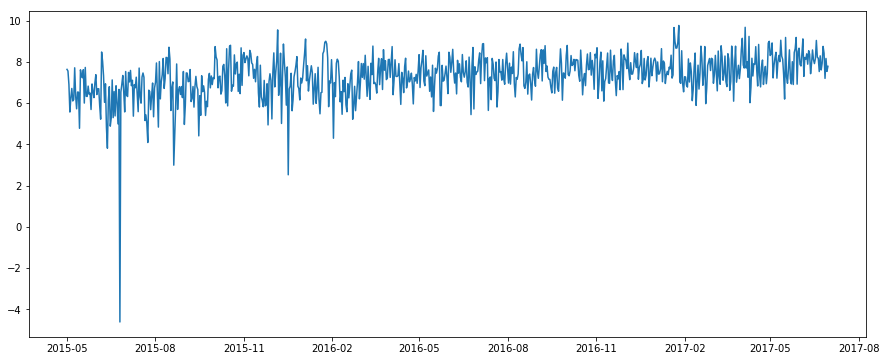

In [39]:
#estimating trend
ts_data_monthly_log_sales = np.log(ts_data_monthly)
plt.plot(ts_data_monthly_log_sales)

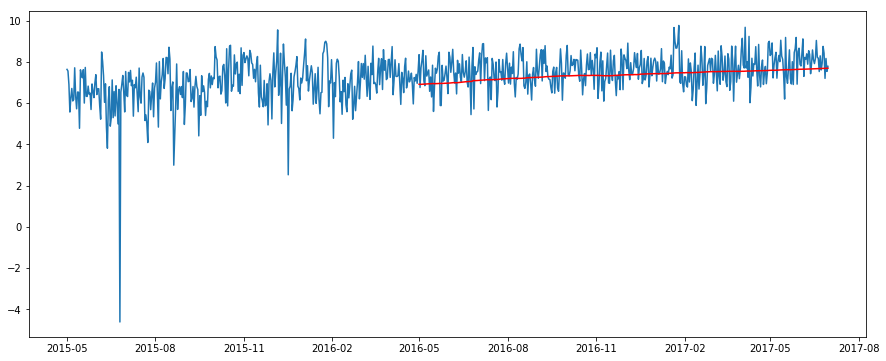

In [40]:
#moving averages 
moving_averages = ts_data_monthly_log_sales.rolling(window=365).mean()
moving_std = ts_data_monthly_log_sales.rolling(window=365).std()
plt.plot(ts_data_monthly_log_sales)
plt.plot(moving_averages, color = 'red')

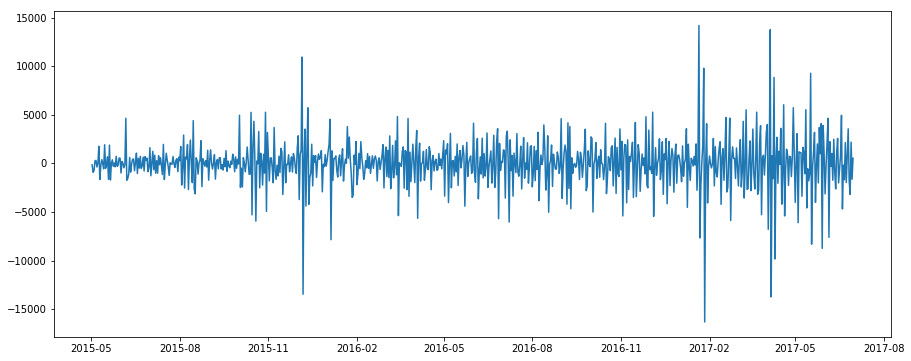

In [41]:
ts_data_monthly_diff_shifting = ts_data_monthly - ts_data_monthly.shift()
plt.plot(ts_data_monthly_diff_shifting)

790

In [61]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(seas_diff1, freq=365)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid


plt.subplot(411)
plt.plot(seas_diff1, label = 'original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label = 'trend')
plt.legend(loc='best')


plt.subplot(413)
plt.plot(seasonal, label = 'seasonal')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label = 'resid')
plt.legend(loc='best')
plt.tight_layout()
rcParams['figure.figsize'] = 15,6

ValueError: This function does not handle missing values

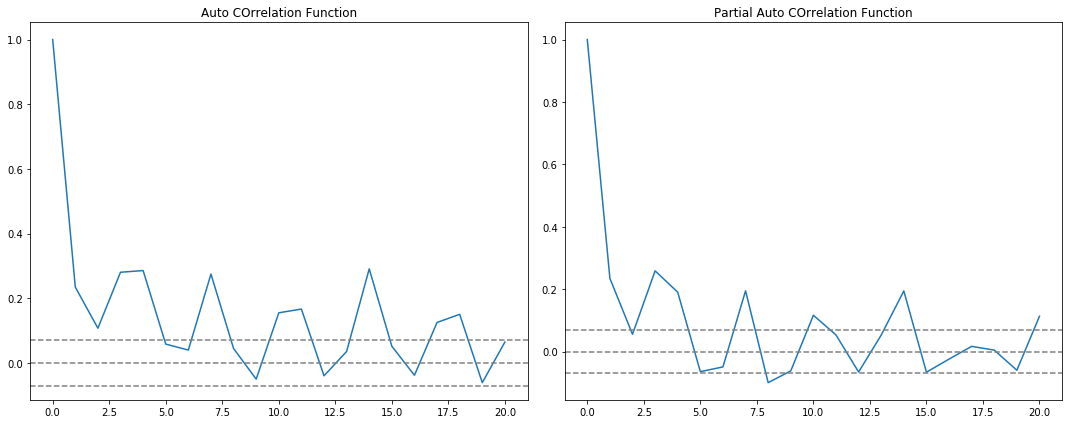

In [51]:
# plot ACF and PACF plots
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(ts_data_monthly, nlags = 20)
lag_pacf = pacf(ts_data_monthly, nlags = 20, method = 'ols')


#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y = 0, linestyle = '--', color = 'gray')
plt.axhline(y = -1.96/np.sqrt(len(ts_data_monthly)), linestyle = '--', color = 'gray')
plt.axhline(y = 1.96/np.sqrt(len(ts_data_monthly)), linestyle = '--', color = 'gray')
plt.title("Auto COrrelation Function")


#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y = 0, linestyle = '--', color = 'gray')
plt.axhline(y = -1.96/np.sqrt(len(ts_data_monthly)), linestyle = '--', color = 'gray')
plt.axhline(y = 1.96/np.sqrt(len(ts_data_monthly)), linestyle = '--', color = 'gray')
plt.title("Partial Auto COrrelation Function")
plt.tight_layout()

### from ACF and PACF value of q can be taken as 8 and value of p from PACF can be taken as 5

### Model Building

In [56]:
from statsmodels.tsa.arima_model import ARIMA

#AR Model
model = ARIMA(ts_data_monthly, order=(0,1,8))
results_AR = model.fit(disp=1)
plt.plot(ts_data_monthly_diff_shifting)
plt.plot(results_AR.fittedvalues, color = 'red')
plt.title('RSS : %.4f' %sum((results_AR.fittedvalues-ts_data_monthly['sale_price_after_promo'])**2))

C:\Users\ali\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\ali\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ValueError: The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.

sale_price_after_promo    0
dtype: int64

In [ ]:
decomposition = sm.tsa.seasonal_decompose(ts_data_monthly['sale_price_after_promo'], model='additive', freq=30)

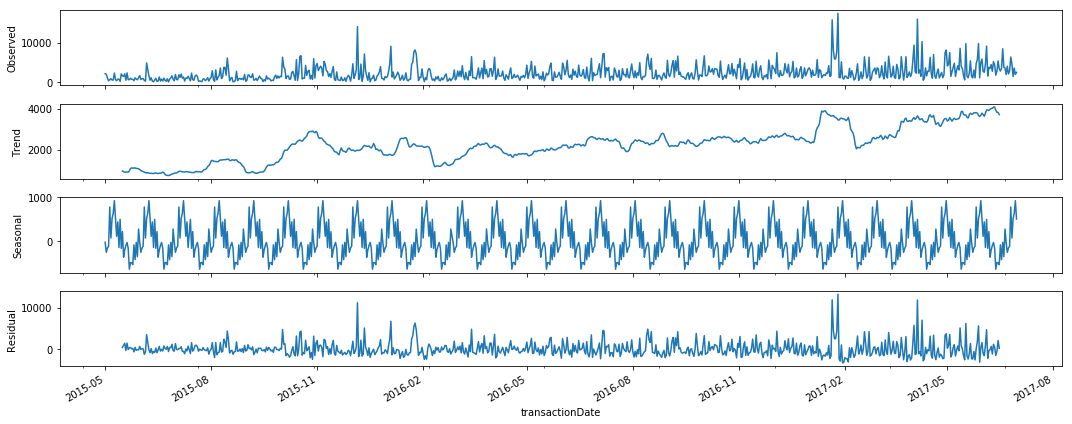

In [27]:
fig = decomposition.plot()
plt.show()

In [ ]:

from statsmodels.tsa.stattools import adfuller

X = series.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

### dividing the data into Train and Validation

In [34]:
split_point = len(ts_sales) - 150
train_set, validation_set = ts_sales[0:split_point], ts_sales[split_point:]
print('train_set %d, validation_set %d' % (len(train_set), len(validation_set)))

train_set 640, validation_set 150


In [35]:
x= ts_sales.values

### estimating trend and eliminating it

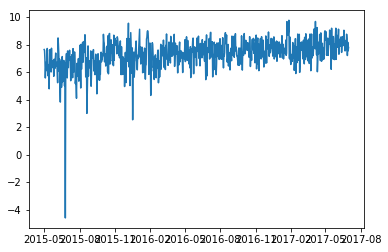

In [9]:
grouping_dates_log = np.log(grouping_dates)
plt.plot(grouping_dates_log)
#the data has more noise than trend